In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_csv(r'C:\Users\Alex\Desktop\Repos\Start_ML\Machine_learning\11_error_matrix\processed_train.csv')
data.head()

,EngineVersion,AppVersion,AvSigVersion,RtpStateBitfield,IsSxsPassiveMode,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,...,Platform_windows8,Processor_x64,Processor_x86,Census_DeviceFamily_Windows.Server,Census_OSArchitecture_arm64,Census_OSArchitecture_x86,Census_GenuineStateName_IS_GENUINE,Census_GenuineStateName_OFFLINE,Census_GenuineStateName_UNKNOWN,HasDetections
0,0.552153,0.530941,0.587952,7.0,0,53447.0,1.0,1.0,1,29,...,0,1,0,0,0,0,1,0,0,0
1,0.448751,0.528931,0.484434,7.0,0,53447.0,1.0,1.0,1,93,...,0,1,0,0,0,0,0,1,0,0
2,0.552153,0.530941,0.557522,7.0,0,53447.0,1.0,1.0,1,86,...,0,1,0,0,0,0,1,0,0,0
3,0.552153,0.530941,0.482759,7.0,0,53447.0,1.0,1.0,1,97,...,0,1,0,0,0,0,1,0,0,0
4,0.493175,0.530941,0.505721,7.0,0,53447.0,1.0,1.0,1,164,...,0,1,0,0,0,0,1,0,0,0


Разобьем выборку на тест и трейн

In [7]:
from sklearn.model_selection import train_test_split

X = data.drop('HasDetections', axis=1)
y = data['HasDetections']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=33)

Обучите LogReg и SVM с помощью классов `LogisticRegression` и `LinearSVC`. Добавьте шаг стандартизации данных в пайплайны. Для разнообразия, возьмем `MinMaxScaler`. Пайплайны запишем в переменные `pipe_lr` и `pipe_svm` соответственно!

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler

# Create pipeline
pipe_svm = Pipeline([('scaler', MinMaxScaler()), ('classifier', LinearSVC())])
pipe_lr = Pipeline([('scaler', MinMaxScaler()), ('classifier', LogisticRegression())])

In [9]:
### Обучаем модели на трейне
pipe_svm.fit(X_train, y_train)
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('classifier', LogisticRegression())])

In [12]:
# Считаем метрику accuracy
print('Accuracy of Logistic regression classifier on test set: {:.3f}'.format(pipe_lr.score(X_test, y_test)))

# Считаем метрику accuracy
print('Accuracy of SVM classifier on test set: {:.3f}'.format(pipe_svm.score(X_test, y_test)))


Accuracy of Logistic regression classifier on test set: 0.843
Accuracy of SVM classifier on test set: 0.840


Постройте ROC для обеих моделей, посчитайте AUC . Конечно же, обучение проводите на трейне, а замеры - на тесте.

Заметьте! Классическая реализация `SVM`, как и в лекциях, не дает никакой оценки вероятности. Чтобы трансформировать выходы в вероятности, на практике мы использовали функцию-сигмоиду. Здесь предлагаем Вам трансформировать выходы `decision_function` в вероятности пропорциональным способом.

Например, вы обучили `SVM`, и на тестовых данных модель выдала следующие выходы `decision_function`:

(-10, -5, 0, +2, +10, +15)

Для каждого числа необходимо сделать преобразование в выражение вида `P(y = +1 | x)`.

С одной стороны, отрицательный знак числа будет сигнализировать нам о том, что `P(y = +1 | x) < 0.5`.

Тогда положительный о том, что `P(y = +1 | x) > 0.5`. 

С другой стороны, для тех объектов, в которых модель уверена больше всего, положим краевые вероятности. Для примера выше:

`P(y = +1 | -10) = 0`, `P(y = +1 | +15) = 1`. Для всех промежуточных объектов применим пропорциональное преобразование. Например:

$$
P(y = +1 | -5) = \frac{|-5-(-10)|}{|-10|} \cdot 0.5
$$

$$
P(y = +1 | +2) = \frac{|+2|}{|+15|} \cdot 0.5 + 0.5
$$
Таким образом мы можем перевести выходы SVM в отрезок `[0;1]` и попробовать интерпретировать новые числа как вероятности, чтобы изобразить калибровочную кривую. При таком преобразовании пропорции внутри первоначально отрицательных и внутри положительных чисел сохраняются.

![](https://storage.yandexcloud.net/klms-public/production/learning-content/48/626/5142/15005/87048/%D0%A0%D0%B8%D1%81%D1%83%D0%BD%D0%BE%D0%BA2.png)

В качестве ответа введите AUC сначала для первой модели, затем для второй.

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

AUC =  0.6890137395616078


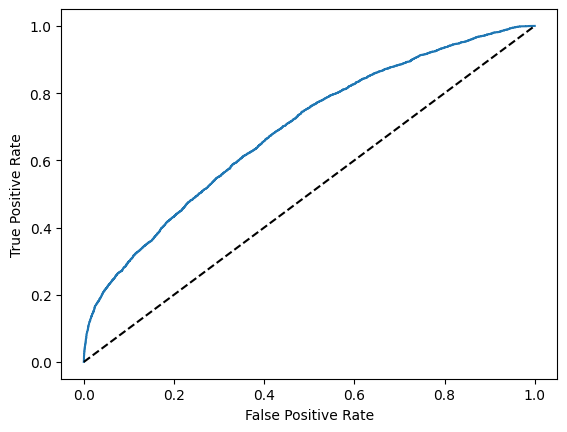

In [16]:
### С изображением рок-кривой для ЛогРега не будет проблем:

fpr, tpr, thresholds = roc_curve(y_test, pipe_lr.predict_proba(X_test)[:,1])
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

# plot 45 degree line
plt.plot([0, 1], [0, 1], 'k--')

AUC_lr = np.trapz(tpr, fpr)

print('AUC = ', AUC_lr)

AUC =  0.6877918214293349


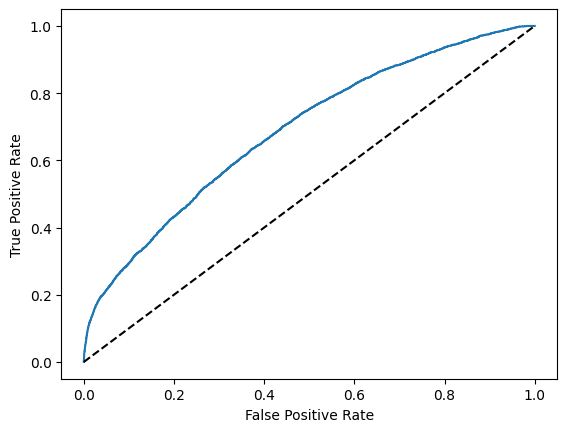

In [21]:
### А для того, чтобы построить и изобразить рок-кривую для SVM, придется
### в начале преобразовать выходы pipe_svm.decision_function

fpr, tpr, thresholds = roc_curve(y_test, pipe_svm.decision_function(X_test))
RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
plt.plot([0, 1], [0, 1], 'k--')

# Вычисляем площадь под кривой
AUC_svm = np.trapz(tpr, fpr) #np.trapz(y, x) это интеграл от y по x

print('AUC = ', AUC_svm)


In [22]:
# Распечатаем AUC_svm и AUC_lr с точностью до 3 знаков после запятой
print('AUC for SVM: {:.3f}'.format(AUC_svm))
print('AUC for Logistic Regression: {:.3f}'.format(AUC_lr))


AUC for SVM: 0.688
AUC for Logistic Regression: 0.689


Постройте калибровочные кривые для обеих моделей. Методом from_estimator для svm воспользоваться не получится.

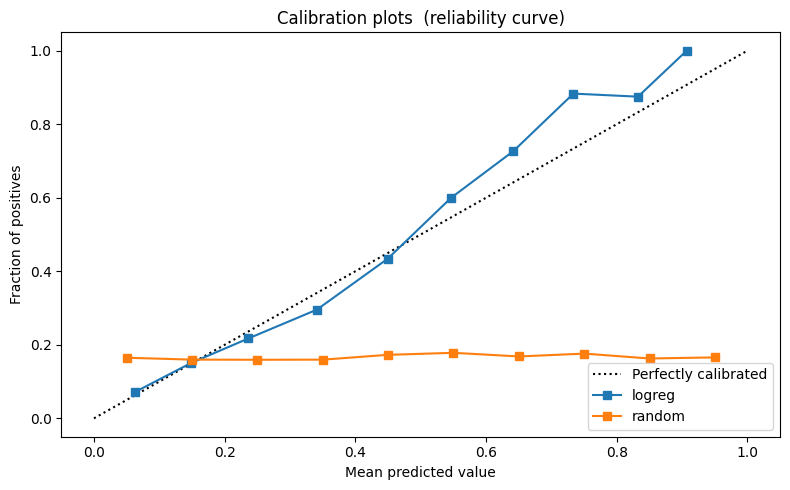

In [23]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

### Предсказания модели на тесте и соответствующая калибровочная кривая
prob_pos = pipe_lr.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="logreg")

### Пусть наши предсказания - случайные, то есть для каждого объекта
### вероятность принадлежности + классу это просто случайное число [0; 1]
prob_pos = np.random.uniform(size=(X_test.shape[0],))
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="random")


plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.tight_layout()




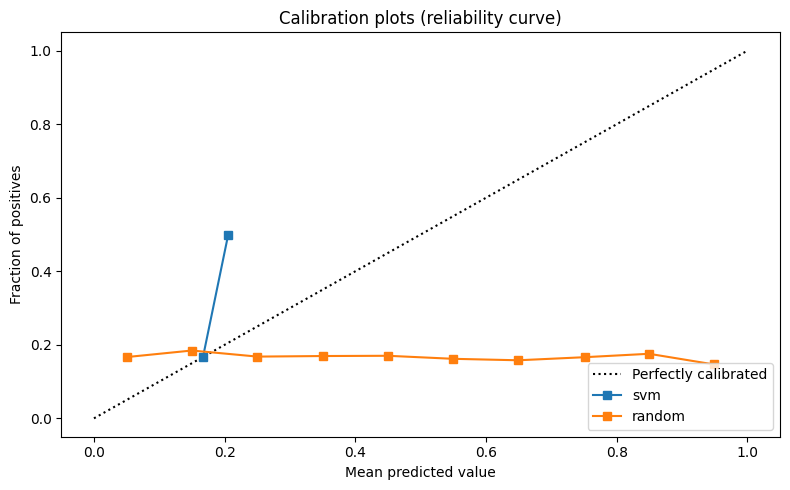

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC # added import statement

# Fit the SVM model to the training data
svm = SVC(probability=True)
svm.fit(X_train, y_train)

# Calibrate the SVM model
calibrated_svm = CalibratedClassifierCV(svm, cv='prefit')
calibrated_svm.fit(X_train, y_train)

plt.figure(figsize=(8, 5))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

# Predict on the test set using the calibrated SVM model
prob_pos = calibrated_svm.predict_proba(X_test)[:, 1]
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="svm")

# Generate random probabilities for comparison
prob_pos = np.random.uniform(size=(X_test.shape[0],))
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="random")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots (reliability curve)')
plt.tight_layout()


**Какая калибровочная кривая ближе к диагонали?  Откалибруйте SVM способом как в практике и изобразите новую кривую!

In [6]:
### Калибровка

from sklearn.calibration import CalibratedClassifierCV

### Your code is here




In [7]:
### Новая кривая

### Your code is here


